In [1]:
import numpy as np  
import re  
import nltk  
from sklearn.datasets import load_files  
import pickle  
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from openpyxl import Workbook
from openpyxl import load_workbook
from itertools import chain
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from decimal import Decimal
from sklearn.model_selection import cross_val_score, GridSearchCV
import string
from stemming.porter2 import stem
from nltk.stem.snowball import SnowballStemmer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/liviu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def load_romanian_data():
    wb = load_workbook('../articole.xlsx')
    sheet = wb['Foaie1']
    data_pos=[]
    data_neg=[]
    data_doubt=[]
    value = ''
    for i in range(1, len(sheet['B'])):
        value = str(sheet['B' + str(i)].value).replace('•', '') # remove special characters
        if bool(re.match('^(?=.*[a-zA-Z])', str(sheet['B' + str(i)].value))): # check if string not empty and has letters
            if sheet['A' + str(i)].value == 1:
                data_pos.append(value)
            elif sheet['A' + str(i)].value == 0:
                data_doubt.append(value)
            elif not sheet['A' + str(i)].value:
                data_neg.append(value)
    print(len(data_pos))
    print(len(data_neg))
    
#     low_limit = 3000
#     high_limit = 10000
#     test_pos = data_pos[:low_limit]
#     train_pos = data_pos[low_limit:high_limit]
#     test_neg = data_neg[:low_limit]
    limit = 300
    test_pos = data_pos[:limit]
    train_pos = data_pos[limit:]
    test_neg = data_neg[:limit]
    train_neg = data_neg[limit:len(data_pos)] # we make sure len of neg data = len of pos data(len neg > len pos initially)
    train_pos = [str(w).lower() for w in train_pos]
    train_pos = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_pos])

    train_neg = [str(w).lower() for w in train_neg]
    train_neg = ([" ".join(j for j in w.split() if len(j) >= 2) for w in train_neg])

    test_pos = [str(w).lower() for w in test_pos]

    test_neg = [str(w).lower() for w in test_neg]
    return train_pos, train_neg, test_pos, test_neg

In [4]:
def prepare_train_and_test(train_pos, train_neg, test_pos, test_neg):
    X_train = list(chain(train_pos, train_neg))
    y_train = np.concatenate((np.ones(len(train_pos), int), np.zeros(len(train_neg), int)))

    X_test = list(chain(test_pos, test_neg))
    y_test = np.concatenate((np.ones(len(test_pos), int), np.zeros(len(test_neg), int)))

    X_train_shuffled, y_train_shuffled =  shuffle(X_train, y_train)
    X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test)

    return X_train_shuffled, y_train_shuffled, X_test_shuffled, y_test_shuffled

In [5]:
def remove_empty_sentences(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)):
        if len(X[i].split()) > 1:
            new_X.append(X[i])
            new_y.append(y[i])
    return new_X, new_y

In [6]:
def feature(X_train):
    stopwords = set(nltk.corpus.stopwords.words('romanian'))
    
    tokenized_sentence = []
    for sentence in X_train:
        tokenized_sentence.append(sentence_punct_tokenization(sentence))

    # NO STOP WORDS
    train_without_stopwords = remove_stopwords(tokenized_sentence, stopwords)

    # NO PUNCTUATION
    train_without_punctuation = remove_punctuation(X_train)

    # STEM WORDS
    stemmed_train = stem_words(X_train)

    # LEMM WORDS
#     lemmatized_train = ([lemmatize_words(sentence) for sentence in X_train])

    # APPLY LITTLE FEATURES
    # feat_train = remove_stopwords(tokenized_sentence, updated_stopwords)
    # feat_train = remove_punctuation(feat_train)
    # feat_train = stem_words(feat_train)
    # feat_train = ([lemmatize_words(sentence) for sentence in feat_train])

    # return based on what features Ii want to extract
    # there are 5 possible ways of returning: extract stop words, extract punctuation,
    # word stem, word lemm, and all the features
    return train_without_stopwords # we choose to extract stop words

In [7]:
def remove_stopwords(sentences_list, updated_stopwords):
    filtered_sentence = []
    for sentence in sentences_list:
        filtered_sentence.append([w for w in sentence if not w in updated_stopwords])
    return repair_sentence(filtered_sentence)


def remove_punctuation(from_train_data):
    table = str.maketrans('', '', string.punctuation)
    no_punctuation = [w.translate(table) for w in from_train_data]
    numbers = re.compile('[0-9]')
    plain_text = [numbers.sub("", word) for word in no_punctuation]
    return plain_text


def repair_sentence(sentence_list):
    return [' '.join(map(str, element)) for element in sentence_list]


def update_stopwords(stopwords):
    do_no_remove_these_sw = ['not', 'no', 'can','has','have','had','must','shan','do', 'should','was','were','won',
                             'are','cannot','does','ain', 'could', 'did', 'is', 'might', 'need', 'would']
    return [word for word in stopwords if word not in do_no_remove_these_sw]


def stem_words(from_text):
    stemmer = SnowballStemmer("romanian")
    stemmer2 = SnowballStemmer("romanian", ignore_stopwords=True)
    return [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in from_text]


def lemmatize_words(sentence):
    from pywsd.utils import lemmatize_sentence
    return lemmatize_sentence(sentence)


def sentence_tokenization(sentence):
    return word_tokenize(sentence)


def sentence_punct_tokenization(sentence):
    return WordPunctTokenizer().tokenize(sentence)


def sentence_split_tokenization(sentence):
    return ([i for i in re.split(' ', sentence) if i])


def remove_apostrophe_words(train):
    train = [w.replace("it's", 'it is')
                     .replace("that's", "that is")
                     .replace("it 's", 'it is')
                     .replace("that 's", "that is")
                     .replace("'ve", " have")
                     .replace("' ve", " have")
                     .replace("won't", "will not")
                     .replace("wo n't", "will not")
                     .replace("don't", "do not")
                     .replace("do n't", "do not")
                     .replace("can't", "can not")
                     .replace("ca n't", "can not")
                     .replace("sha n't", "shall not")
                     .replace("shan't", "shall not")
                     .replace("n't", " not")
                     .replace("'re", " are")
                     .replace("'d", " would")
                     .replace("'ll", " will") for w in train]
    return train

In [8]:
def k_neigh_scores(X_train, y_train, X_test, y_test):
#     k_range = range(1, 23, 2)
    k_range = range(1, 5, 2)
    accuracy = []
    f1score_average = []
    recall_average = []
    precision_average = []
    color = ['blue', 'orange', 'red', 'green', 'coral',
             'grey', 'indigo', 'gold', 'lime', 'olive',
             'pink', 'navy', 'magenta', 'yellow', 'tomato',
             'turquoise', 'yellowgreen', 'maroon', 'lightblue', 'black', 'lightcoral']

    for k in k_range:
        print(k)
        text_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', KNeighborsClassifier(n_neighbors=k)),
                             ])
        model = text_clf.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        y_predict_proba = model.predict_proba(X_test)
        probabilities = np.array(y_predict_proba)[:, 1]

        # METRICS
        accuracy.append(accuracy_score(y_test, y_predict))
        f1score_average.append(f1_score(y_test, y_predict, average="weighted"))
        recall_average.append(recall_score(y_test, y_predict,  pos_label=1, average="binary"))
        precision_average.append(precision_score(y_test, y_predict, average="weighted"))

        # ROC + AUC
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color[k - 1], lw=1, label='ROC (area = %f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right", fontsize='9')
    plt.show()

    plt.grid(True)
    plt.xlabel('k values')
    plt.ylabel('metrics')
    plt.plot(k_range, accuracy, color='orange', label='accuracy')
    plt.plot(k_range, f1score_average, color='green', label='f1score')
    plt.plot(k_range, recall_average, color='blue', label='recall')
    plt.plot(k_range, precision_average, color='red', label='precision')
    plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
    plt.legend(loc="lower right", fontsize='10')
    plt.show()

In [9]:
def build_models_NLP(classifier, X_train, y_train):
    ######################################################## KNN ######################################################
    if (classifier == 'KNeighborsClassifier'):
        param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        build_classifier = globals()[classifier]()
        build_classifier = GridSearchCV(build_classifier, param_grid)

    ################################################ LOGISTIC REGRESSION ###############################################
    if (classifier == 'LogisticRegression'):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
        build_classifier = globals()[classifier]()
        build_classifier = GridSearchCV(build_classifier, param_grid)

    ####################################################### SVM ########################################################
    # SVC
    if (classifier == 'SVC'):
        build_classifier = globals()[classifier](kernel='rbf',probability=True)

    # LINEAR SVC
    if (classifier == 'LinearSVC'):
        build_classifier = globals()[classifier]()

    # NUSVC
    if (classifier == 'NuSVC'):
        build_classifier = globals()[classifier](kernel='rbf',probability=True, nu=0.3)

    ################################################### NAIVE BAYES ####################################################
    # MULTINOMIAL NB
    if (classifier == 'MultinomialNB'):
        build_classifier = globals()[classifier]()

    # BERNOULLI NB
    if (classifier == 'BernoulliNB'):
        build_classifier = globals()[classifier]()

    ################################################## DECISION TREE ###################################################
    if (classifier == 'DecisionTreeClassifier'):
        param_grid = {'random_state': [i for i in range(1, 20)]}
        build_classifier = globals()[classifier]()
        build_classifier = GridSearchCV(build_classifier, param_grid)

    ################################################## RANDOM FOREST ###################################################
    if (classifier == 'RandomForestClassifier'):
        param_grid = {'random_state': [i for i in range(1, 20)]}
        build_classifier = globals()[classifier]()
        build_classifier = GridSearchCV(build_classifier, param_grid)

    # N-GRAM
    # text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(2, 3), analyzer = 'word')),
    #                      ('tfidf', TfidfTransformer()),
    #                      ('clf', build_classifier)])

    # for GaussianNB we need DenseTransformer
    # text_clf = Pipeline([('vectorizer', CountVectorizer()),
    #                      ('to_dense', DenseTransformer()),
    #                      ('classifier', build_classifier)
    #                     ])

    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', build_classifier),
                         ])
    model = text_clf.fit(X_train, y_train)
    # print(build_classifier.best_estimator_)
    # print(build_classifier.best_score_)

    return model

In [10]:
def evaluate_model(model, X_test, y_test):
    y_predict = model.predict(X_test)

    print('-----------------------------------------------SIMPLE------------------------------------------------------')
    print('Accuracy:', accuracy_score(y_test, y_predict))
    print('-----------------------------------------------------------------------------------------------------------')
    # print('F1 for each class: ', f1_score(y_test, y_predict, average=None))
    print('Average f1: ', f1_score(y_test, y_predict, average="weighted"))
    print('-----------------------------------------------------------------------------------------------------------')
    # print('Recall for each class: ', recall_score(y_test, y_predict, average=None))
    print('Average recall: ', recall_score(y_test, y_predict, pos_label=1, average="binary"))
    print('-----------------------------------------------------------------------------------------------------------')
    # print('Precision for each class is: ', precision_score(y_test, y_predict, average=None))
    print('Average precision: ', precision_score(y_test, y_predict, average="weighted"))

    # no normalize CONFUSION MATRIX
    cnf_matrix = confusion_matrix(y_test, y_predict)
    print(cnf_matrix)
    plt.clf()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative', 'Positive']
    plt.title('Confusion Matrix - Test Data - Without Normalization')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j]) + " = " + str(cnf_matrix[i][j]))
    plt.show()

    # normalize CONFUSION MATRIX
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    print(cnf_matrix_normalized)
    plt.clf()
    plt.imshow(cnf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Greens)
    classNames = ['Negative', 'Positive']
    plt.title('Confusion Matrix - Test Data - With Normalization')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            x = Decimal(cnf_matrix_normalized[i][j])
            output = round(x, 4)
            plt.text(j, i, str(s[i][j]) + " = " + str(output))
    plt.show()

    # ROC + AUC
    y_predict_proba = model.predict_proba(X_test)
    probabilities = np.array(y_predict_proba)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    print('-----------------------------------------------------------------------------------------------------------')
    print('Roc auc: ', roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def cross_validation(model, X_cross, y_cross):
    '''
        ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score',
        'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score',
        'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error',
        'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision',
        'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro',
        'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
    '''

    print('------------------------------------------CROSS VALIDATION--------------------------------------------------')
    # ACCURACY
    scores = cross_val_score(estimator = model, X = X_cross, y = y_cross, cv=10, scoring='accuracy')
    print("Accuracy cross values: ", scores)
    print("Average cross accuracy:", scores.mean())
    print("Accuracy error: ", scores.std())
    print('-----------------------------------------------------------------------------------------------------------')
    # F1 SCORE
    scores = cross_val_score(estimator = model, X = X_cross, y = y_cross, cv=10, scoring='f1_weighted')
    print("F1 cross values: ", scores)
    print("Average cross f1:", scores.mean())
    print("F1 error: ", scores.std())
    print('-----------------------------------------------------------------------------------------------------------')
    # RECALL
    scores = cross_val_score(estimator = model, X = X_cross, y = y_cross, cv=10, scoring='recall_weighted')
    print("Recall cross values: ", scores)
    print("Average cross recall:", scores.mean())
    print("Recall error: ", scores.std())
    print('-----------------------------------------------------------------------------------------------------------')
    # PRECISION
    scores = cross_val_score(estimator = model, X = X_cross, y = y_cross, cv=10, scoring='precision_weighted')
    print("Precision cross values: ", scores)
    print("Average cross precision:", scores.mean())
    print("Precision error: ", scores.std())
    print('-----------------------------------------------------------------------------------------------------------')
    # ROC AUC
    scores = cross_val_score(estimator = model, X = X_cross, y = y_cross, cv=10, scoring='roc_auc')
    print("Roc auc cross values: ", scores)
    print("Cross roc auc:", scores.mean())

In [12]:
# from cube.api import Cube       # import the Cube object
# cube=Cube(verbose=True)         # initialize it
# cube.load("ro")                 # select the desired language (it will auto-download the model on first run)

In [13]:
# text=["salut sunt Ondras", "am 16 ani am lasat totul in urma"]
# sentences=[]
# for sentence in text:
#     sentences.append(cube(sentence))            # call with your own text (string) to obtain the annotations

# Main

In [14]:
train_pos, train_neg, test_pos, test_neg = load_romanian_data()
print("train pos len: " + str(len(train_pos)))
print("train neg len: " + str(len(train_neg)))
print("test pos len: " + str(len(test_pos)))
print("test neg len: " + str(len(test_neg)))

X_train, y_train, X_test, y_test = prepare_train_and_test(train_pos, train_neg, test_pos, test_neg)
feat_train = feature(X_train)
# feat_train = remove_punctuation(feat_train)
# feat_train, y_train = remove_empty_sentences(feat_train, y_train)
X_train, y_train = remove_empty_sentences(X_train, y_train)
# X_test, y_test = remove_empty_sentences(X_test, y_test)
nr_small_sentences = 0;
for sentence in feat_train:
    if len(sentence.split()) < 2:
        nr_small_sentences += 1
print(nr_small_sentences)

11077
23509
train pos len: 10777
train neg len: 10777
test pos len: 300
test neg len: 300
37


In [15]:
feat_train

['- doreşte captiv maşină atâta timp , tânărul corporatist găsit imediat părţile bune : văd modă bărbile acum , aşa faptul n - rad ani zile degrabă avantaj .',
 'scafandru căuta tab - scufundat sparge blindajul acestuia sticlă şampanie subacvatică , oficializând preluarea vehiculului marină , adăugat amiralul harbuz .',
 'taie copac și drumul mâinile murdare sevă și binevenit printre , adaugă woodman .',
 'așa l - încadrat clasa risc seismic ultra - extrem , adică pică mic cutremur , petrecere lăutari sprijină domn gras .',
 'mare ruşinea , spus 500 milioane mătuşi zonele planetei .',
 'vizibilă atât giurgiului , olteniţei , brâncoveanu luică , stea apărută brusc cer înştiinţat mii păstori zonă într - hypermarket apropiere promoţie specială crăciun bormaşini .',
 'troleibuze oferă motiv plus meargă jos .',
 'când faci aşa - lua căldura calorifere pensionari amărâţi .',
 'erau !',
 'bogat om lume , magnatul bill gates devenit oficial sărac om lume achitat integral sejur revelion poiana 

In [16]:
%%time
feat_train_cube = []
# for sentence in feat_train[:10]:
#     feat_train_cube.append(cube(sentence))
# print(feat_train_cube[0])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


In [17]:
for i in range(3):
    print(str(y_train[i]) + "\t" + feat_train[i])

1	- doreşte captiv maşină atâta timp , tânărul corporatist găsit imediat părţile bune : văd modă bărbile acum , aşa faptul n - rad ani zile degrabă avantaj .
1	scafandru căuta tab - scufundat sparge blindajul acestuia sticlă şampanie subacvatică , oficializând preluarea vehiculului marină , adăugat amiralul harbuz .
1	taie copac și drumul mâinile murdare sevă și binevenit printre , adaugă woodman .


In [18]:
idx = 111
print(len(feat_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(str(y_train[idx]) + " " + feat_train[idx])

21554
21447
600
600
1 staţia deteriorată ploua , construi şopron spaţial adăposti intemperii .


1
3


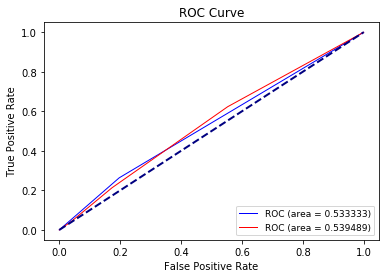

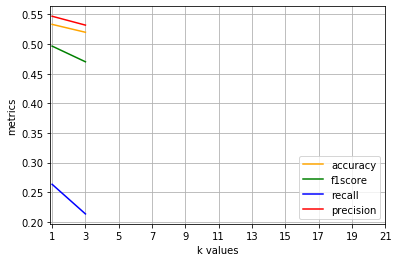

In [19]:
k_neigh_scores(X_train, y_train, X_test, y_test)

In [20]:
lr = 'LogisticRegression'
gnb = 'GaussianNB'
bnb = 'BernoulliNB'
mnb = 'MultinomialNB'
lsvc = 'LinearSVC'
svc = 'SVC'
nsvc = 'NuSVC'
knn = 'KNeighborsClassifier'
dt = 'DecisionTreeClassifier'
rf = 'RandomForestClassifier'

# build model based on what features I want to extract
# model = build_models_NLP(mnb, feat_train, y_train)
# model = build_models_NLP(mnb, X_train, y_train) # text cleaning, n-grams
model = build_models_NLP(mnb, feat_train, y_train) # sw, punct, stem
# model = build_models_NLP(lr, updated_feat_train, y_train) # lemm, all_features

# EVALUATE MODEL - RETURN METRICS VALUES
evaluate_model(model, X_test, y_test)

# CROSS VALIDATION
cross_validation(model, feat_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [21554, 21447]

In [ ]:
nr_strange_chars = 0
nr_empty_strings = 0;
nr_one_word_strings = 0
nr_two_word_strings = 0
nr_three_word_strings = 0

for sentence in feat_train:
    if '•' in sentence:
        nr_strange_chars += 1
    if not sentence:
        nr_empty_strings += 1
    if len(sentence.split()) == 1:
        nr_one_word_strings += 1
    elif len(sentence.split()) == 2:
         nr_two_word_strings += 1
    elif len(sentence.split()) == 3:
         nr_three_word_strings += 1
print("number of strange chars: " + str(nr_strange_chars))
print("number of empty strings: " + str(nr_empty_strings))
print("number of one word strings: " + str(nr_one_word_strings))
print("number of two word strings: " + str(nr_two_word_strings))
print("number of three word strings: " + str(nr_three_word_strings))
idx = 3

print(X_train[:idx])
file = open('X_train.txt', 'w')
for sentence in X_train[:3]:
    file.write(sentence + '\n')
file.close()

In [ ]:
print(X_test[2])